<a href="https://colab.research.google.com/github/Dena-Kazerani/stock-prediction/blob/main/Copia_de_Copia_de_StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import finance API and get historical stock data
!pip install yfinance
#!pip install -U scikit-learn
import yfinance as yf
import os
import json
import pandas as pd


DATA_PATH = "msft_data.json"
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

# Save file to json in case we need it later.  This prevents us from having to re-download it every time.
msft_hist.to_json(DATA_PATH)


     |████████████████████████████████| 6.4 MB 6.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1986-03-14,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
1986-03-17,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
1986-03-18,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
1986-03-19,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0


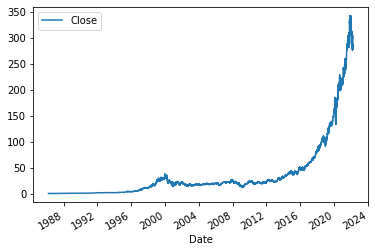

In [ ]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [ ]:


# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]



In [ ]:


# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)



In [ ]:


# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

In [ ]:
import sklearn
# Random forest hyperparameter tuning using optuna

def objective(trial):
      n_estimators = trial.suggest_int('n_estimators', 2, 20)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()


In [ ]:
!pip install optuna
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

     |████████████████████████████████| 308 kB 6.3 MB/s 
     |████████████████████████████████| 81 kB 6.0 MB/s 
     |████████████████████████████████| 210 kB 46.3 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 150 kB 47.2 MB/s 
     |████████████████████████████████| 113 kB 45.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ebb28f7a640f2a422183dde2b3527166f66aad9242b483d64ed6150f6f1bdb49
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


[I 2022-03-23 12:54:25,522] A new study created in memory with name: no-name-c698f158-3851-46c3-a10a-2fa9ea4b2644
[I 2022-03-23 12:54:27,776] Trial 0 finished with value: 0.47795100222717146 and parameters: {'n_estimators': 19, 'max_depth': 5.950954531709606}. Best is trial 0 with value: 0.47795100222717146.
[I 2022-03-23 12:54:28,084] Trial 1 finished with value: 0.49554565701559017 and parameters: {'n_estimators': 16, 'max_depth': 1.768669894017502}. Best is trial 1 with value: 0.49554565701559017.
[I 2022-03-23 12:54:28,395] Trial 2 finished with value: 0.4906458797327395 and parameters: {'n_estimators': 17, 'max_depth': 1.7707865602094268}. Best is trial 1 with value: 0.49554565701559017.
[I 2022-03-23 12:54:30,092] Trial 3 finished with value: 0.49031180400890867 and parameters: {'n_estimators': 18, 'max_depth': 21.295549831305568}. Best is trial 1 with value: 0.49554565701559017.
[I 2022-03-23 12:54:30,533] Trial 4 finished with value: 0.489532293986637 and parameters: {'n_estima

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.5011135857461024
Best hyperparameters: {'n_estimators': 2, 'max_depth': 1.7559995911500224}


In [ ]:
#Test the hyperparameter tuned random forest on test set 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

model=RandomForestClassifier(n_estimators = trial.params["n_estimators"], max_depth = trial.params["max_depth"], random_state = 1)
# Evaluate error of predictions
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds) 

0.5

In [ ]:

from xgboost import XGBClassifier
def objective_xgb(trial):
  params={
          "n_estimators" : trial.suggest_int('n_estimators', 2, 10000),
          "max_depth": trial.suggest_int("max_depth", 1, 32),
          "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
          "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
          "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
          "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
          "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
          "n_jobs": 1,
  }
  clf = XGBClassifier(**params)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2022-03-23 13:42:00,183] A new study created in memory with name: no-name-e8794fe3-f3e2-45d1-9de5-a24238e4c95c
[I 2022-03-23 13:42:47,757] Trial 0 finished with value: 0.47717149220489974 and parameters: {'n_estimators': 3315, 'max_depth': 4, 'alpha': 0.2833188368414135, 'lambda': 6.983047431512594e-08, 'learning_rate': 0.005495969385739635, 'colsample_bytree': 0.48492911890448964, 'subsample': 0.5397130994481613, 'min_child_weight': 74.3017312403502}. Best is trial 0 with value: 0.47717149220489974.


In [ ]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
#define the LSTM neural network
input_data = kl.Input(shape=(1,train.shape[1]))
lstm = kl.LSTM(5, input_shape=(1,train.shape[1]), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)
lstmNN=Model(input_data, out)
lstmNN._estimator_type = "classifier"

In [ ]:

from xgboost import XGBClassifier
#define base models
level0 = []
level0.append(('rf', RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)))
level0.append(('lstm', lstmNN))
level0.append(('xgbc', XGBClassifier()))

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(train[predictors], train["Target"])

TypeError: ignored

In [ ]:


from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)



0.5

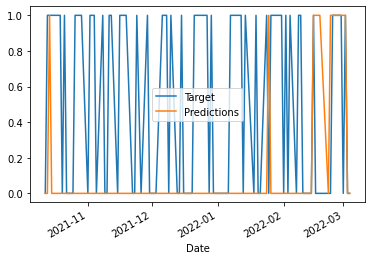

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()